In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imagetouse/Screenshot from 2024-07-30 02-11-55.png


In [2]:
!pip install -q transformers datasets

In [3]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install torchvision

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-n8ximdu6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-n8ximdu6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2a420edb307c9bdf640f036d3b196bed474b8593
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.

In [4]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


### Verification

In [5]:
from huggingface_hub import notebook_login

notebook_login()

### Global variables

In [6]:
model_checkpoint = "microsoft/layoutlmv2-base-uncased"
batch_size = 4

### Load dataset

In [7]:
from datasets import load_dataset

dataset = load_dataset("nielsr/docvqa_1200_examples")
dataset

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 200
    })
})

In [8]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'query': {'de': Value(dtype='string', id=None),
  'en': Value(dtype='string', id=None),
  'es': Value(dtype='string', id=None),
  'fr': Value(dtype='string', id=None),
  'it': Value(dtype='string', id=None)},
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bounding_boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), length=-1, id=None),
 'answer': {'match_score': Value(dtype='float64', id=None),
  'matched_text': Value(dtype='string', id=None),
  'start': Value(dtype='int64', id=None),
  'text': Value(dtype='string', id=None)}}

In [9]:
updated_dataset = dataset.map(lambda example: {"question": example["query"]["en"]}, remove_columns=["query"])
updated_dataset = updated_dataset.map(
    lambda example: {"answer": example["answers"][0]}, remove_columns=["answer", "answers"]
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [10]:
updated_dataset = updated_dataset.filter(lambda x: len(x["words"]) + len(x["question"].split()) < 512)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

### Remove OCR Features

In [11]:
updated_dataset = updated_dataset.remove_columns("words")
updated_dataset = updated_dataset.remove_columns("bounding_boxes")

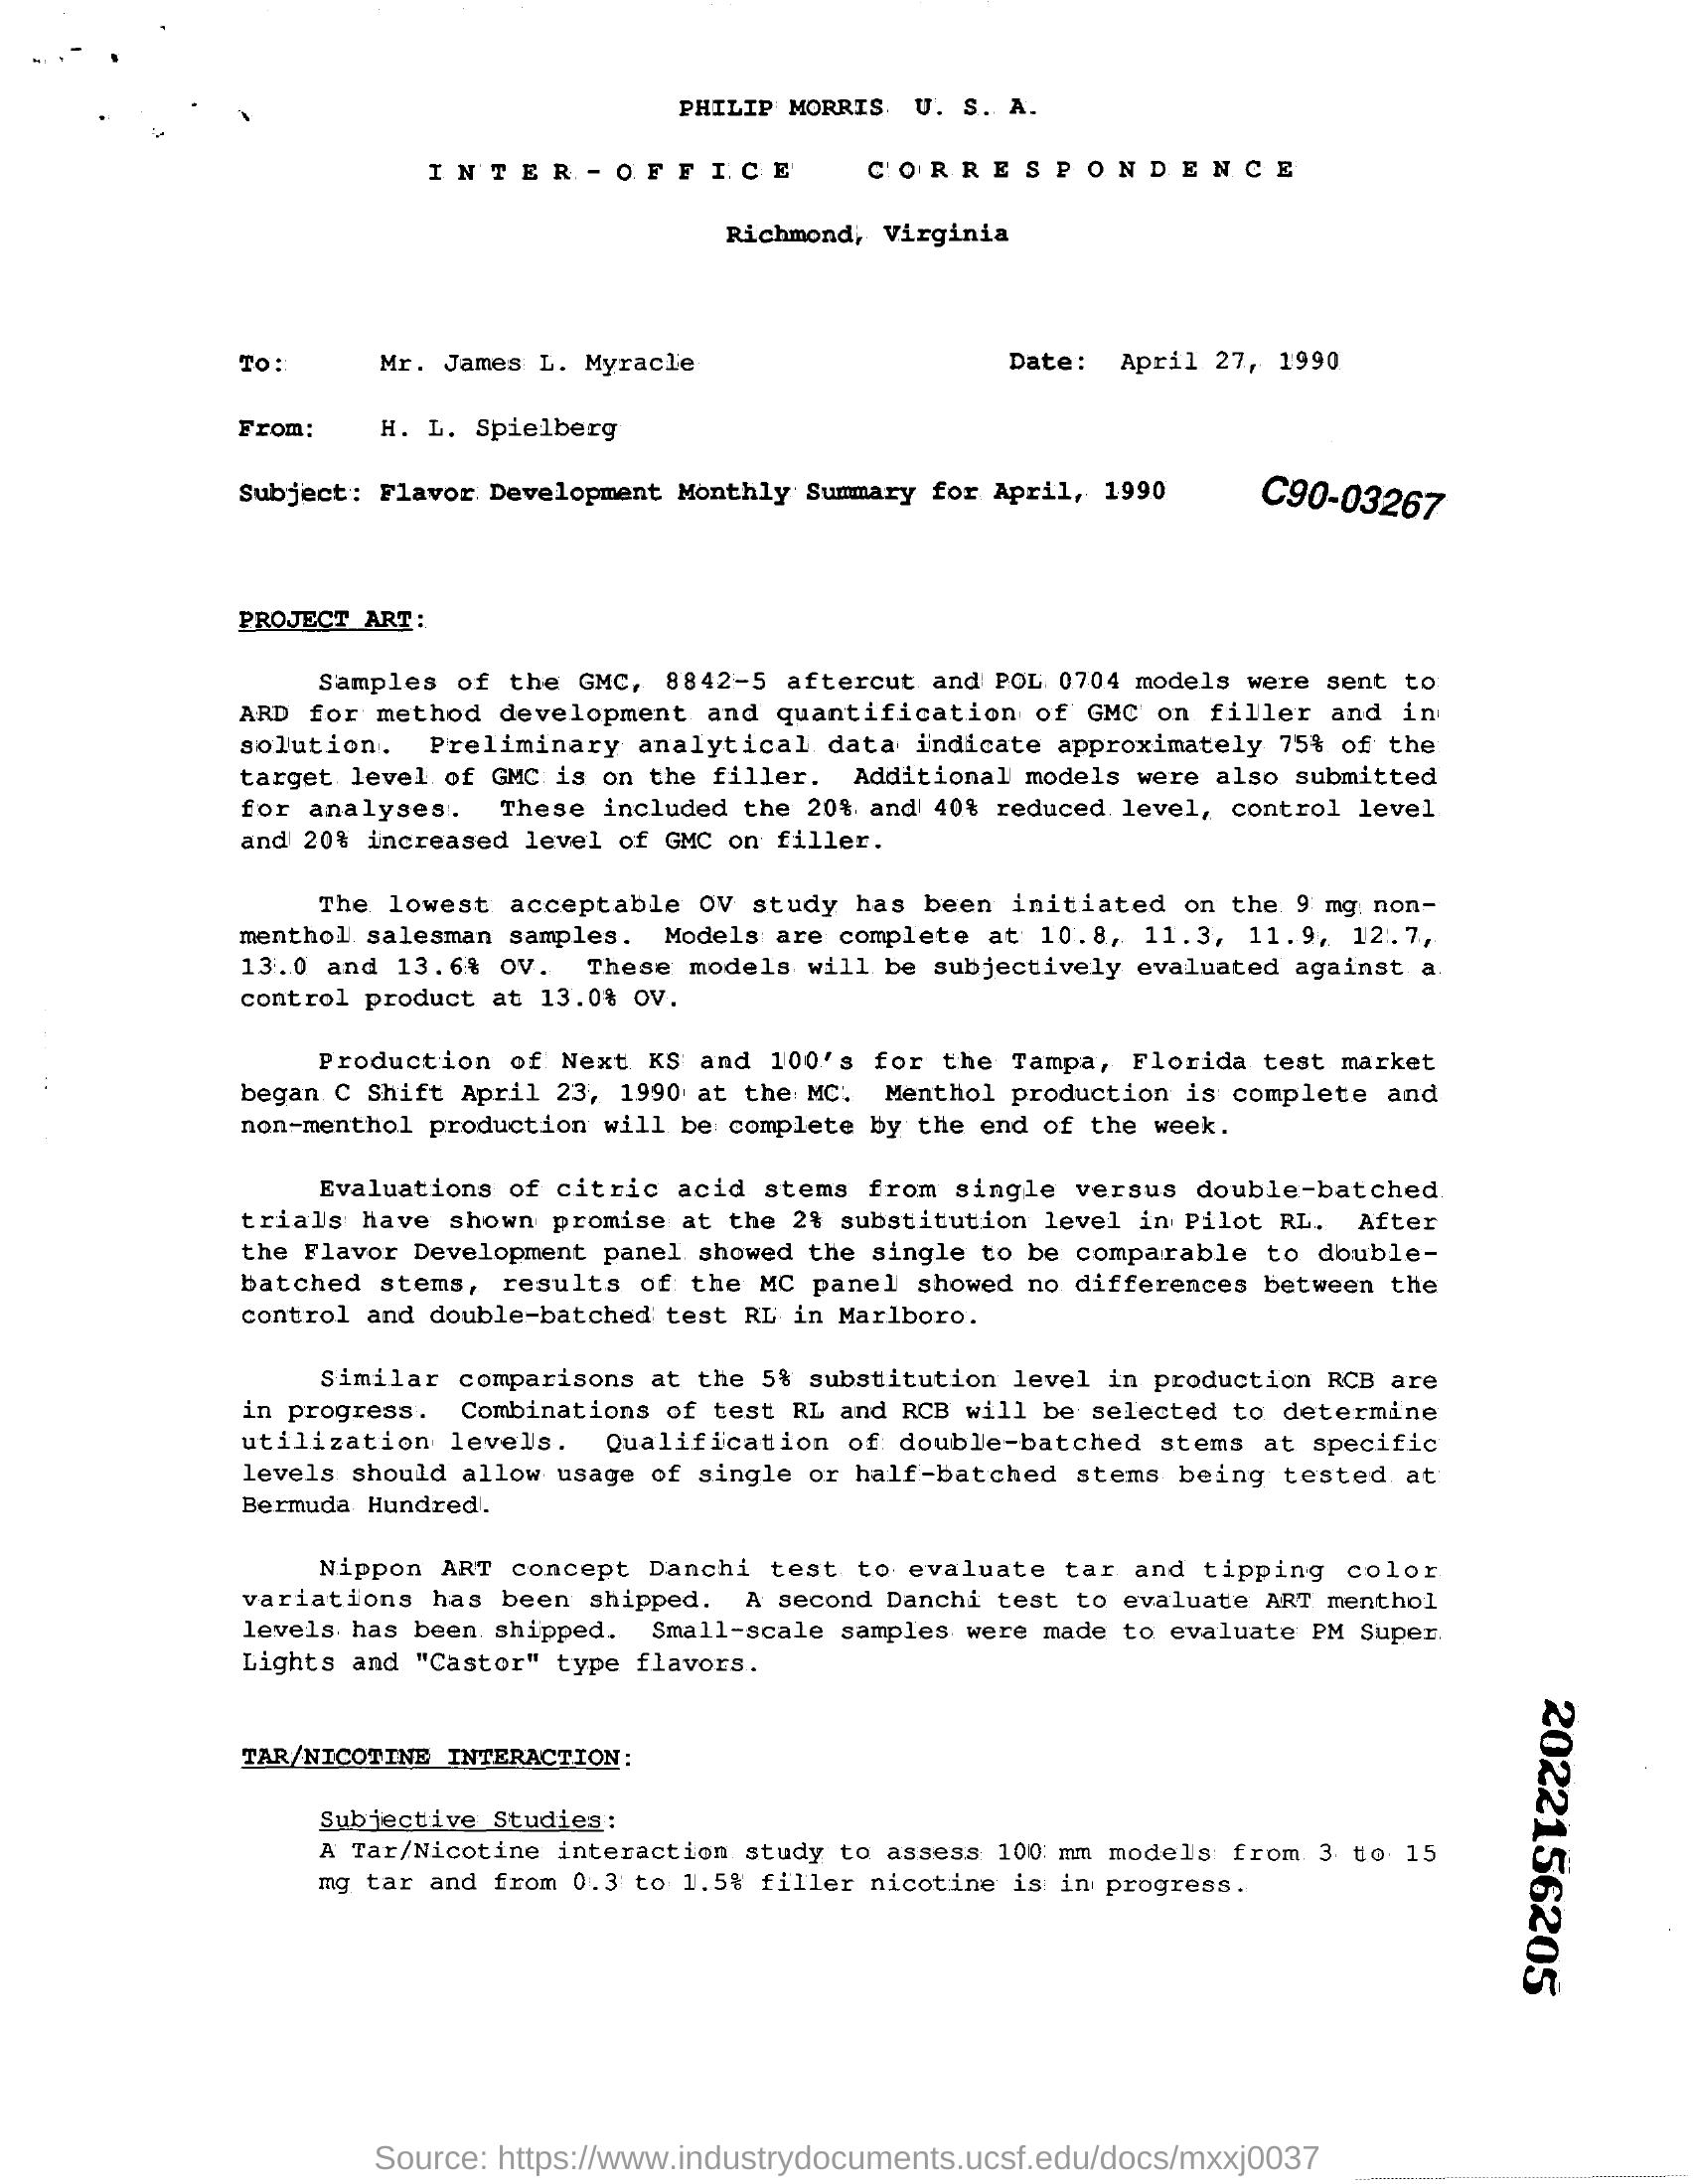

In [12]:
updated_dataset["train"][11]["image"]

# Preprocess the data

In [13]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(model_checkpoint)

2024-08-01 01:26:52.805640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 01:26:52.805765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 01:26:52.938494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [14]:
image_processor = processor.image_processor


def get_ocr_words_and_boxes(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    encoded_inputs = image_processor(images)

    examples["image"] = encoded_inputs.pixel_values
    examples["words"] = encoded_inputs.words
    examples["boxes"] = encoded_inputs.boxes

    return examples

### Apply function to all datasets with ease

In [15]:
dataset_with_ocr = updated_dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=2)

Map:   0%|          | 0/904 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Map:   0%|          | 0/190 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


## Encode the text

In [16]:
tokenizer = processor.tokenizer

In [17]:
def subfinder(words_list, answer_list):
    matches = []
    start_indices = []
    end_indices = []
    for idx, i in enumerate(range(len(words_list))):
        if words_list[i] == answer_list[0] and words_list[i : i + len(answer_list)] == answer_list:
            matches.append(answer_list)
            start_indices.append(idx)
            end_indices.append(idx + len(answer_list) - 1)
    if matches:
        return matches[0], start_indices[0], end_indices[0]
    else:
        return None, 0, 0

### Par example

In [18]:
example = dataset_with_ocr["train"][1]
words = [word.lower() for word in example["words"]]
match, word_idx_start, word_idx_end = subfinder(words, example["answer"].lower().split())
print("Question: ", example["question"])
print("Words:", words)
print("Answer: ", example["answer"])
print("start_index", word_idx_start)
print("end_index", word_idx_end)

Question:  Who is in  cc in this letter?
Words: ['wie', 'baw', 'brown', '&', 'williamson', 'tobacco', 'corporation', 'research', '&', 'development', 'internal', 'correspondence', 'to:', 'r.', 'h.', 'honeycutt', 'ce:', 't.f.', 'riehl', 'from:', '.', 'c.j.', 'cook', 'date:', 'may', '8,', '1995', 'subject:', 'review', 'of', 'existing', 'brainstorming', 'ideas/483', 'the', 'major', 'function', 'of', 'the', 'product', 'innovation', 'graup', 'is', 'to', 'develop', 'marketable', 'nove!', 'products', 'that', 'would', 'be', 'profitable', 'to', 'manufacture', 'and', 'sell.', 'novel', 'is', 'defined', 'as:', 'of', 'a', 'new', 'kind,', 'or', 'different', 'from', 'anything', 'seen', 'or', 'known', 'before.', 'innovation', 'is', 'defined', 'as:', 'something', 'new', 'or', 'different', 'introduced;', 'act', 'of', 'innovating;', 'introduction', 'of', 'new', 'things', 'or', 'methods.', 'the', 'products', 'may', 'incorporate', 'the', 'latest', 'technologies,', 'materials', 'and', 'know-how', 'available'

In [19]:
def encode_dataset(examples, max_length=512):
    questions = examples["question"]
    words = examples["words"]
    boxes = examples["boxes"]
    answers = examples["answer"]

    # encode the batch of examples and initialize the start_positions and end_positions
    encoding = tokenizer(questions, words, boxes, max_length=max_length, padding="max_length", truncation=True)
    start_positions = []
    end_positions = []

    # loop through the examples in the batch
    for i in range(len(questions)):
        cls_index = encoding["input_ids"][i].index(tokenizer.cls_token_id)

        # find the position of the answer in example's words
        words_example = [word.lower() for word in words[i]]
        answer = answers[i]
        match, word_idx_start, word_idx_end = subfinder(words_example, answer.lower().split())

        if match:
            # if match is found, use `token_type_ids` to find where words start in the encoding
            token_type_ids = encoding["token_type_ids"][i]
            token_start_index = 0
            while token_type_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(encoding["input_ids"][i]) - 1
            while token_type_ids[token_end_index] != 1:
                token_end_index -= 1

            word_ids = encoding.word_ids(i)[token_start_index : token_end_index + 1]
            start_position = cls_index
            end_position = cls_index

            # loop over word_ids and increase `token_start_index` until it matches the answer position in words
            # once it matches, save the `token_start_index` as the `start_position` of the answer in the encoding
            for id in word_ids:
                if id == word_idx_start:
                    start_position = token_start_index
                else:
                    token_start_index += 1

            # similarly loop over `word_ids` starting from the end to find the `end_position` of the answer
            for id in word_ids[::-1]:
                if id == word_idx_end:
                    end_position = token_end_index
                else:
                    token_end_index -= 1

            start_positions.append(start_position)
            end_positions.append(end_position)

        else:
            start_positions.append(cls_index)
            end_positions.append(cls_index)

    encoding["image"] = examples["image"]
    encoding["start_positions"] = start_positions
    encoding["end_positions"] = end_positions

    return encoding

## Encode the whole dataset

In [20]:
encoded_train_dataset = dataset_with_ocr["train"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["train"].column_names
)
encoded_test_dataset = dataset_with_ocr["test"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["test"].column_names
)

Map:   0%|          | 0/904 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [21]:
encoded_train_dataset.features

{'image': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='uint8', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'start_positions': Value(dtype='int64', id=None),
 'end_positions': Value(dtype='int64', id=None)}

### Load the model with AutoModelForDocumentQuestionAnswering using the same checkpoint as in the preprocessing.

In [22]:
from transformers import AutoModelForDocumentQuestionAnswering

model = AutoModelForDocumentQuestionAnswering.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['layoutlmv2.visual_segment_embedding', 'qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import TrainingArguments

# REPLACE THIS WITH YOUR REPO ID
repo_id = "pacman2223/test-mod"

training_args = TrainingArguments(
    output_dir=repo_id,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    save_steps=100,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [24]:
#  Batch examples together

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=processor,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TrainOutput(global_step=2260, training_loss=1.3547983888239987, metrics={'train_runtime': 3265.2546, 'train_samples_per_second': 2.769, 'train_steps_per_second': 0.692, 'total_flos': 4880019948011520.0, 'train_loss': 1.3547983888239987, 'epoch': 10.0})

In [ ]:
trainer.create_model_card()
trainer.push_to_hub()

## Examples

In [28]:
example = dataset["test"][2]
question = example["query"]["en"]
image = example["image"]
print(question)
print(example["answers"])

print(image)

Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?
['TRRF Vice President', 'lee a. waller']
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=850x1644 at 0x7AA45CE08220>


### Using my fine-tuned model

In [29]:
from transformers import pipeline

qa_pipeline = pipeline("document-question-answering", model="pacman2223/test-mod")
qa_pipeline(image, question)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.9394049048423767,
  'answer': 'Lee A. Waller',
  'start': 55,
  'end': 57}]

In [50]:
image = '/kaggle/input/imagetouse/Screenshot from 2024-07-30 02-11-55.png'
question = 'projects'

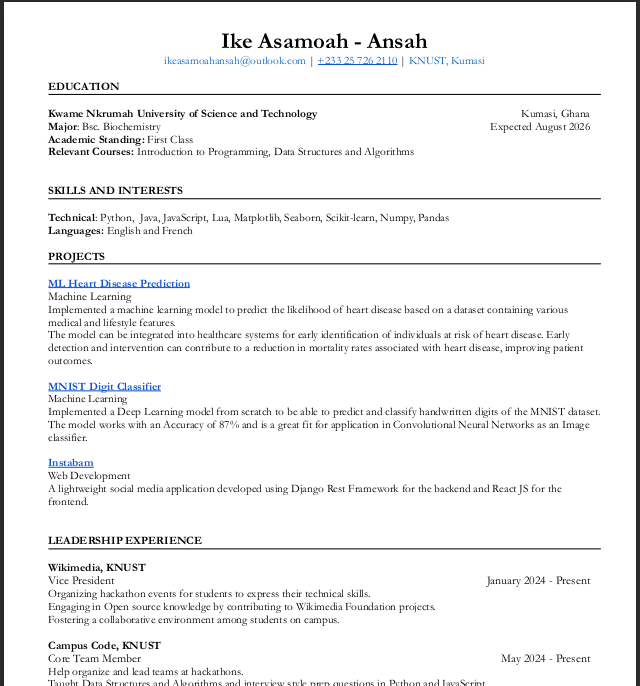

In [51]:
from PIL import Image

img = Image.open(image)
img

In [52]:
qa_pipeline = pipeline("document-question-answering", model="pacman2223/test-mod")
qa_pipeline(img, question)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 9.285286978411023e-06,
  'answer': 'Machine Leatning',
  'start': 61,
  'end': 62}]

## My Custom Pipeline

In [42]:
import torch
from transformers import AutoProcessor
from transformers import AutoModelForDocumentQuestionAnswering

processor = AutoProcessor.from_pretrained("pacman2223/test-mod")
model = AutoModelForDocumentQuestionAnswering.from_pretrained("pacman2223/test-mod")

with torch.no_grad():
    encoding = processor(img.convert("RGB"), question, return_tensors="pt")
    outputs = model(**encoding)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits
    predicted_start_idx = start_logits.argmax(-1).item()
    predicted_end_idx = end_logits.argmax(-1).item()

processor.tokenizer.decode(encoding.input_ids.squeeze()[predicted_start_idx : predicted_end_idx + 1])

'[CLS]'